# EDA

In [163]:
import numpy as np
import scipy.signal as signal

# Step 1: Band-pass Filtering
def bandpass_filter(signal_data, lowcut=5.0, highcut=15.0, signal_freq=200, filter_order=1):
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = signal.butter(filter_order, [low, high], btype="band")
    filtered_signal = signal.filtfilt(b, a, signal_data)
    return filtered_signal

# Step 2: Derivative - highlights the slope of the QRS complex
def derivative(signal):
    # 5-point derivative
    derivative_filter = np.array([-1, -2, 0, 2, 1]) / 8.0  # Scale to get the right amplitude
    return np.convolve(signal, derivative_filter, mode='same')


# Step 4: Integration - moving window integration
def moving_window_integration(signal, window_size=30):
    window = np.ones(window_size) / window_size
    return np.convolve(signal, window, mode='same')



def pan_tompkins(ecg_signal, lowcut=5.0, highcut=15.0, signal_freq=200, filter_order=1, window_size=30, height=0.6):
    # Step 1: Band-pass Filtering
    filtered_ecg = bandpass_filter(ecg_signal, lowcut, highcut, signal_freq, filter_order)

    # Step 2: Derivative - highlights the slope of the QRS complex
    derivative_ecg = derivative(filtered_ecg)

    # Step 3: Squaring - to enhance QRS peaks
    squared_ecg = np.square(derivative_ecg)

    # Step 4: Integration - moving window integration
    integrated_ecg = moving_window_integration(squared_ecg, window_size)

    r_peaks = signal.find_peaks(integrated_ecg, height=height)
    
    return integrated_ecg, r_peaks[0]

In [164]:
import pandas as pd
import numpy as np
import wfdb
import ast
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load Raw Data

In [165]:
def load_raw_data(df, sampling_rate, path, max_data=None):
    # Choose the correct filename column based on sampling_rate
    filenames = df.filename_lr if sampling_rate == 100 else df.filename_hr
    
    # If max_data is specified, limit the filenames list to max_data elements
    if max_data is not None:
        filenames = filenames[:max_data]
    
    # Use list comprehension to read and store data efficiently
    data = [wfdb.rdsamp(path+f) for f in tqdm(filenames)]
    
    # Extract signal data and convert to numpy array
    data = np.array([signal for signal, meta in data])
    
    return data


In [166]:
path = 'ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

Y = Y.head(100)

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

print('data shpae:', X.shape)
Y[['scp_codes']]

100%|██████████| 100/100 [00:00<00:00, 651.98it/s]

data shpae: (100, 1000, 12)


,scp_codes
ecg_id,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"
2,"{'NORM': 80.0, 'SBRAD': 0.0}"
3,"{'NORM': 100.0, 'SR': 0.0}"
4,"{'NORM': 100.0, 'SR': 0.0}"
5,"{'NORM': 100.0, 'SR': 0.0}"
...,...
96,"{'LVH': 100.0, 'SR': 0.0}"
97,"{'NORM': 80.0, 'SR': 0.0}"
98,"{'NORM': 100.0, 'SARRH': 0.0}"


# Train-Valid-Test Set Splitting

According to the source of the [dataset](https://physionet.org/content/ptb-xl/1.0.1/), there are recommended ***stratified 10-folds***, where the ***same patients are kept within the same folds***. Moreover, ***9th fold and 10th are of higher quality, which are recommeded to be used as validation set and test set***. 


> 5. Cross-validation Folds: recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

Here, I will split compile fold 1-8 as train sets, fold 9 as validation set, and fold 10 as test set.

### Train

In [167]:
import matplotlib.pyplot as plt

In [168]:
sample = X[0][:, 0]
# plt.plot(sample)

In [169]:
# ecg_filtered, rs = pan_tompkins(sample, signal_freq=100, height=0.015, lowcut=3, highcut=45, filter_order=1, window_size=30)

In [170]:
sample.shape

(1000,)

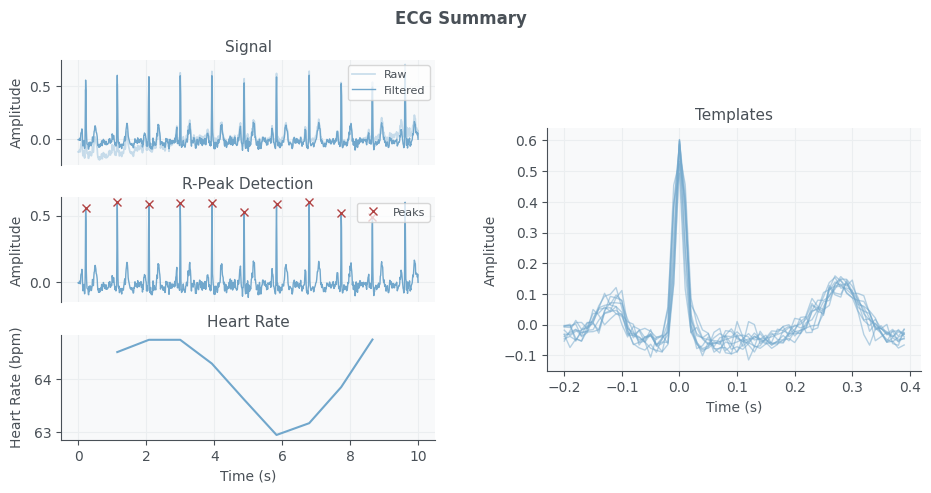

In [178]:
from biosppy.signals import ecg
out = ecg.ecg(signal=sample, sampling_rate=100, show=True)

In [183]:

x1, x2, x3, x4, x5, x6, x7 = out

In [185]:
x1.shape, x2.shape, x3.shape, x4.shape, x5.shape, x6.shape, x7.shape

((1000,), (1000,), (10,), (60,), (10, 60), (9,), (9,))

In [190]:
x3

array([ 22, 115, 208, 300, 393, 488, 583, 679, 773, 865])